# Training at scale with the Vertex AI Training Service

## Introduction

In this notebook we'll make the jump from training locally, to do training in the cloud. We'll take advantage of Google Cloud's [Vertex AI Training Service](https://cloud.google.com/vertex-ai/). 

Vertex AI Training Service is a managed service that allows the training and deployment of ML models without having to provision or maintain servers. The infrastructure is handled seamlessly by the managed service for us.

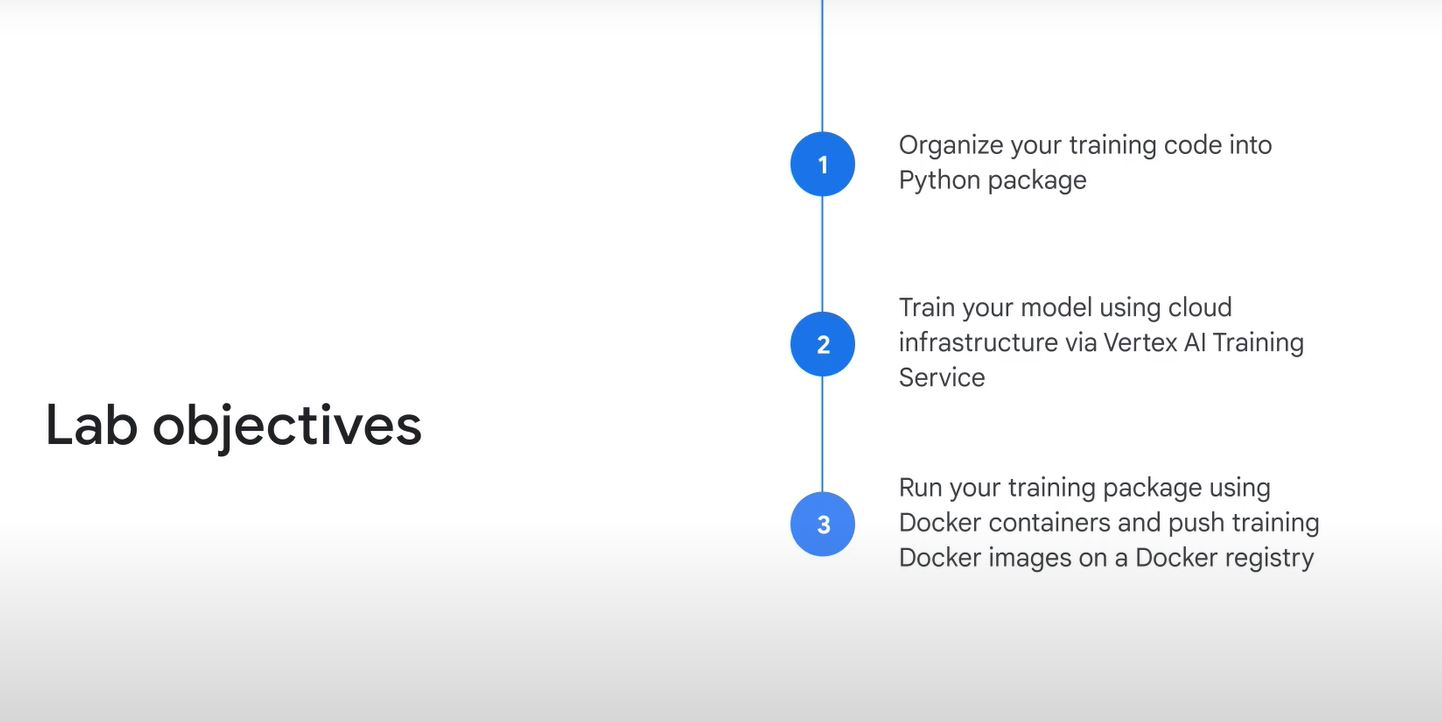

In [ ]:
from google import api_core
from google.cloud import bigquery

### Create a Cloud Storage bucket
Create a bucket using the Google Cloud console:

1. In your Cloud Console, click on the Navigation menu (Navigation menu icon), and select Cloud Storage.

2. Click on + Create and choose a Regional bucket.

Set a unique name (use your project ID because it is unique).

3. Click Create.

4. If prompted Public access will be prevented click Confirm.

In [1]:
!pip freeze | grep tensorflow || pip install tensorflow
#!pip install tensorflow-gpu

tensorflow==2.10.0
tensorflow-estimator==2.10.0
tensorflow-gpu==2.10.1
tensorflow-io==0.27.0
tensorflow-io-gcs-filesystem==0.27.0


**Note:** **Restart** the kernel before proceeding further (On the Notebook menu, select Kernel > Restart Kernel > Restart).

Specify your project name and bucket name in the cell below.

Change the following cell as necessary:

In [ ]:
# Change below if necessary
PROJECT = !gcloud config get-value project  # noqa: E999
PROJECT = PROJECT[0]
BUCKET = "qwiklabs-gcp-01-36e38d362a08"
REGION = "europe-west3"

OUTDIR = f"gs://{BUCKET}/taxifare/data"

%env PROJECT=$PROJECT
%env BUCKET=$BUCKET
%env REGION=$REGION
%env OUTDIR=$OUTDIR
%env TFVERSION=2.8

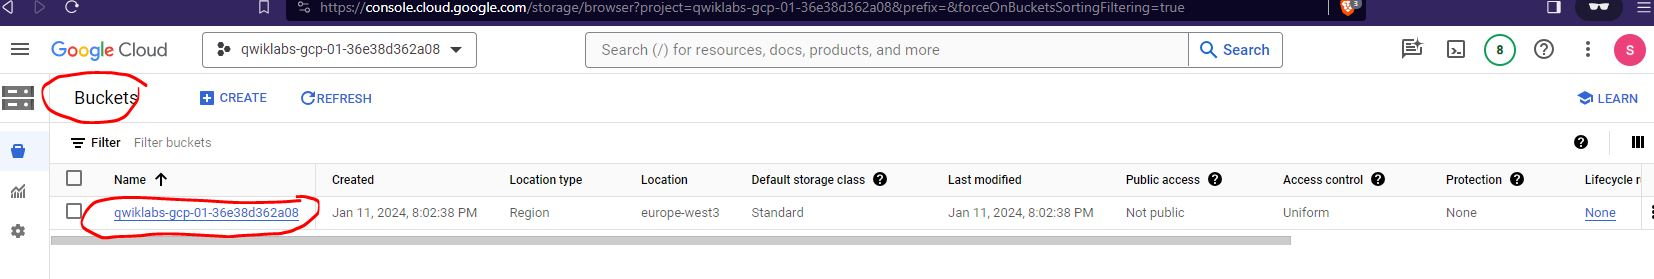

Confirm below that the bucket is regional and its region equals to the specified region:

In [ ]:
%%bash
gsutil ls -Lb gs://$BUCKET | grep "gs://\|Location"
echo $REGION

In [ ]:
%%bash
gcloud config set project $PROJECT
gcloud config set ai/region $REGION

## Create BigQuery tables

If you have not already created a BigQuery dataset for our data, run the following cell:

In [ ]:
bq = bigquery.Client(project=PROJECT)
dataset = bigquery.Dataset(bq.dataset("taxifare"))

try:
    bq.create_dataset(dataset)
    print("Dataset created")
except api_core.exceptions.Conflict:
    print("Dataset already exists")

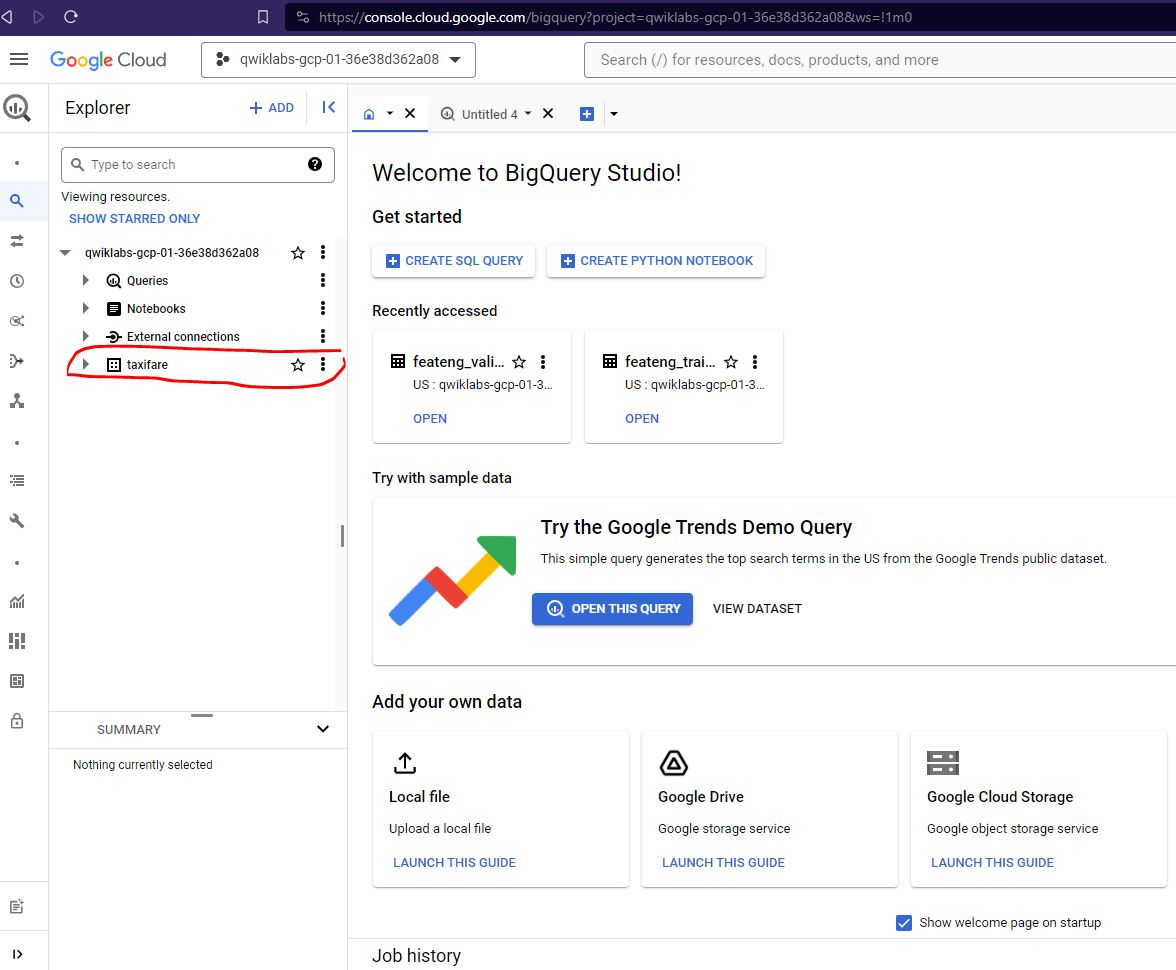

Let's create a table with 1 million examples.

Note that the order of columns is exactly what was in our CSV files.

In [ ]:
%%bigquery

CREATE OR REPLACE TABLE taxifare.feateng_training_data AS

SELECT
    (tolls_amount + fare_amount) AS fare_amount,
    pickup_datetime,
    pickup_longitude AS pickuplon,
    pickup_latitude AS pickuplat,
    dropoff_longitude AS dropofflon,
    dropoff_latitude AS dropofflat,
    passenger_count*1.0 AS passengers,
    'unused' AS key
FROM `nyc-tlc.yellow.trips`
WHERE ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 1000)) = 1
AND
    trip_distance > 0
    AND fare_amount >= 2.5
    AND pickup_longitude > -78
    AND pickup_longitude < -70
    AND dropoff_longitude > -78
    AND dropoff_longitude < -70
    AND pickup_latitude > 37
    AND pickup_latitude < 45
    AND dropoff_latitude > 37
    AND dropoff_latitude < 45
    AND passenger_count > 0

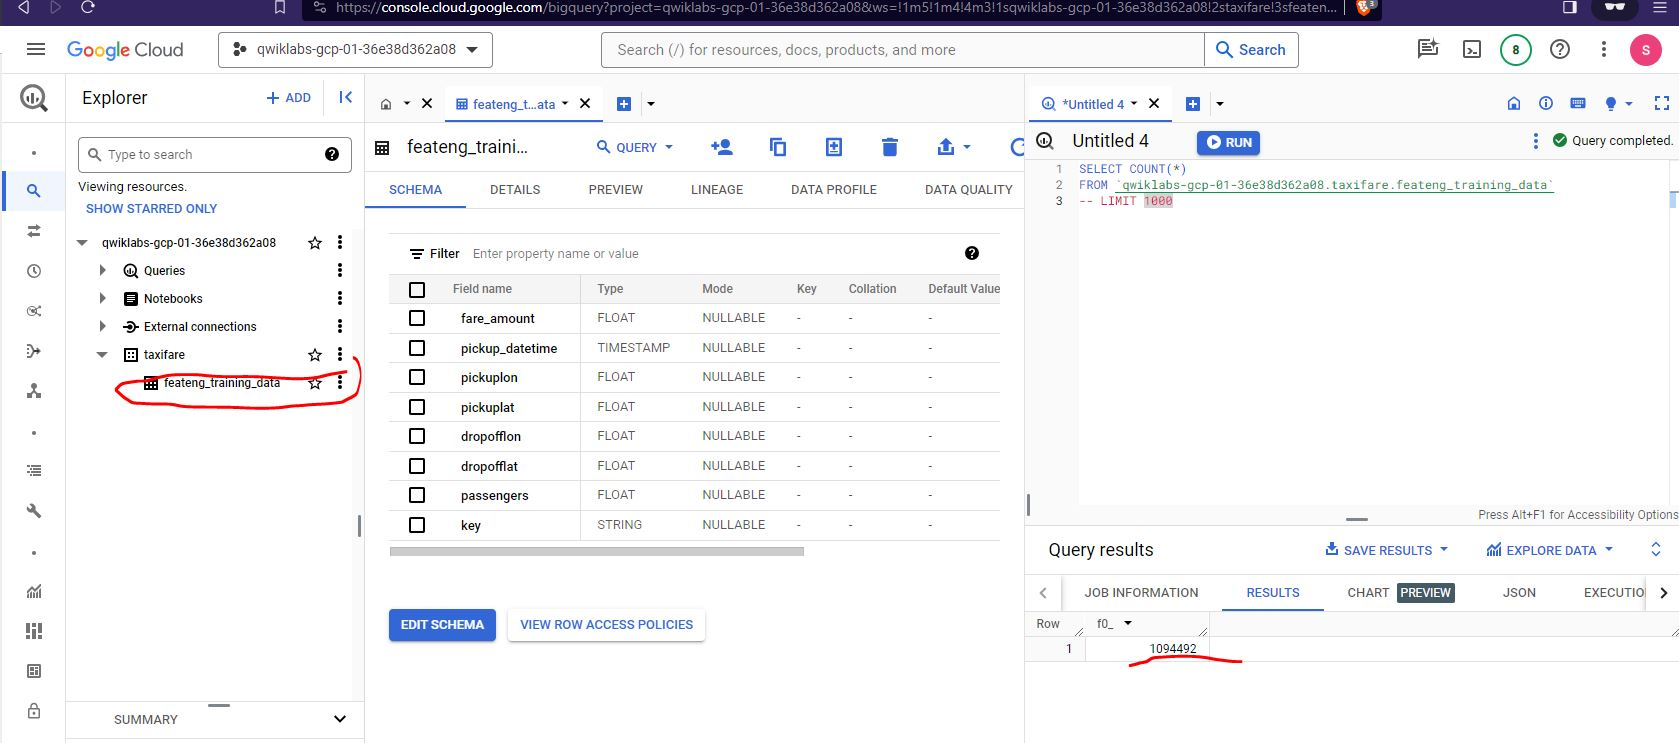

Make the validation dataset be 1/10 the size of the training dataset.

In [ ]:
%%bigquery

CREATE OR REPLACE TABLE taxifare.feateng_valid_data AS

SELECT
    (tolls_amount + fare_amount) AS fare_amount,
    pickup_datetime,
    pickup_longitude AS pickuplon,
    pickup_latitude AS pickuplat,
    dropoff_longitude AS dropofflon,
    dropoff_latitude AS dropofflat,
    passenger_count*1.0 AS passengers,
    'unused' AS key
FROM `nyc-tlc.yellow.trips`
WHERE ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 10000)) = 2
AND
    trip_distance > 0
    AND fare_amount >= 2.5
    AND pickup_longitude > -78
    AND pickup_longitude < -70
    AND dropoff_longitude > -78
    AND dropoff_longitude < -70
    AND pickup_latitude > 37
    AND pickup_latitude < 45
    AND dropoff_latitude > 37
    AND dropoff_latitude < 45
    AND passenger_count > 0

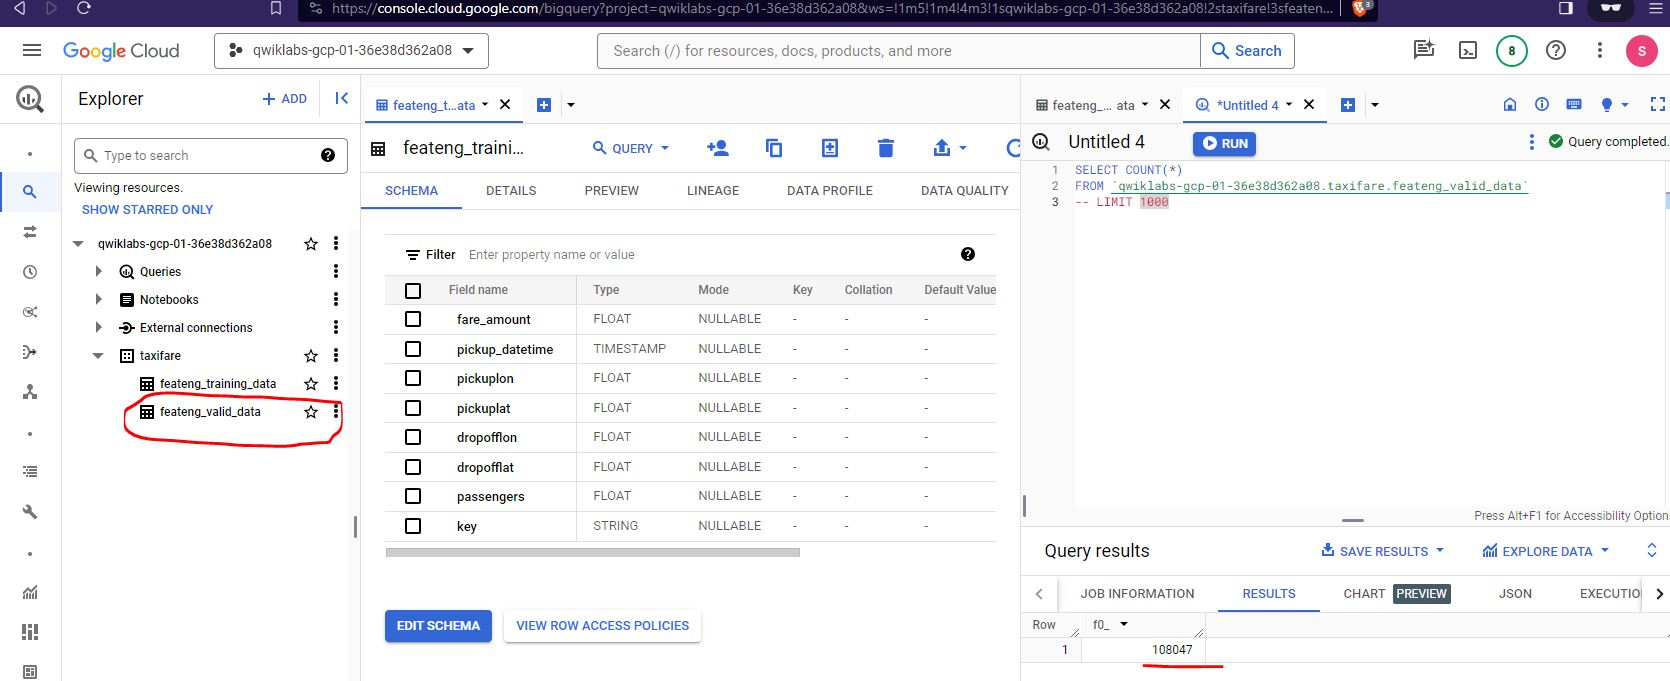

## Export the tables as CSV files

In [ ]:
%%bash

echo "Deleting current contents of $OUTDIR"
gsutil -m -q rm -rf $OUTDIR

echo "Extracting training data to $OUTDIR"
bq --location=US extract \ # change as required
   --destination_format CSV  \
   --field_delimiter "," --noprint_header \
   taxifare.feateng_training_data \
   $OUTDIR/taxi-train-*.csv

echo "Extracting validation data to $OUTDIR"
bq --location=US extract \ # change as required
   --destination_format CSV  \
   --field_delimiter "," --noprint_header \
   taxifare.feateng_valid_data \
   $OUTDIR/taxi-valid-*.csv

gsutil ls -l $OUTDIR

Confirm that you have created both the training and validation datasets in Google Cloud Storage.

In [ ]:
!gsutil ls gs://$BUCKET/taxifare/data

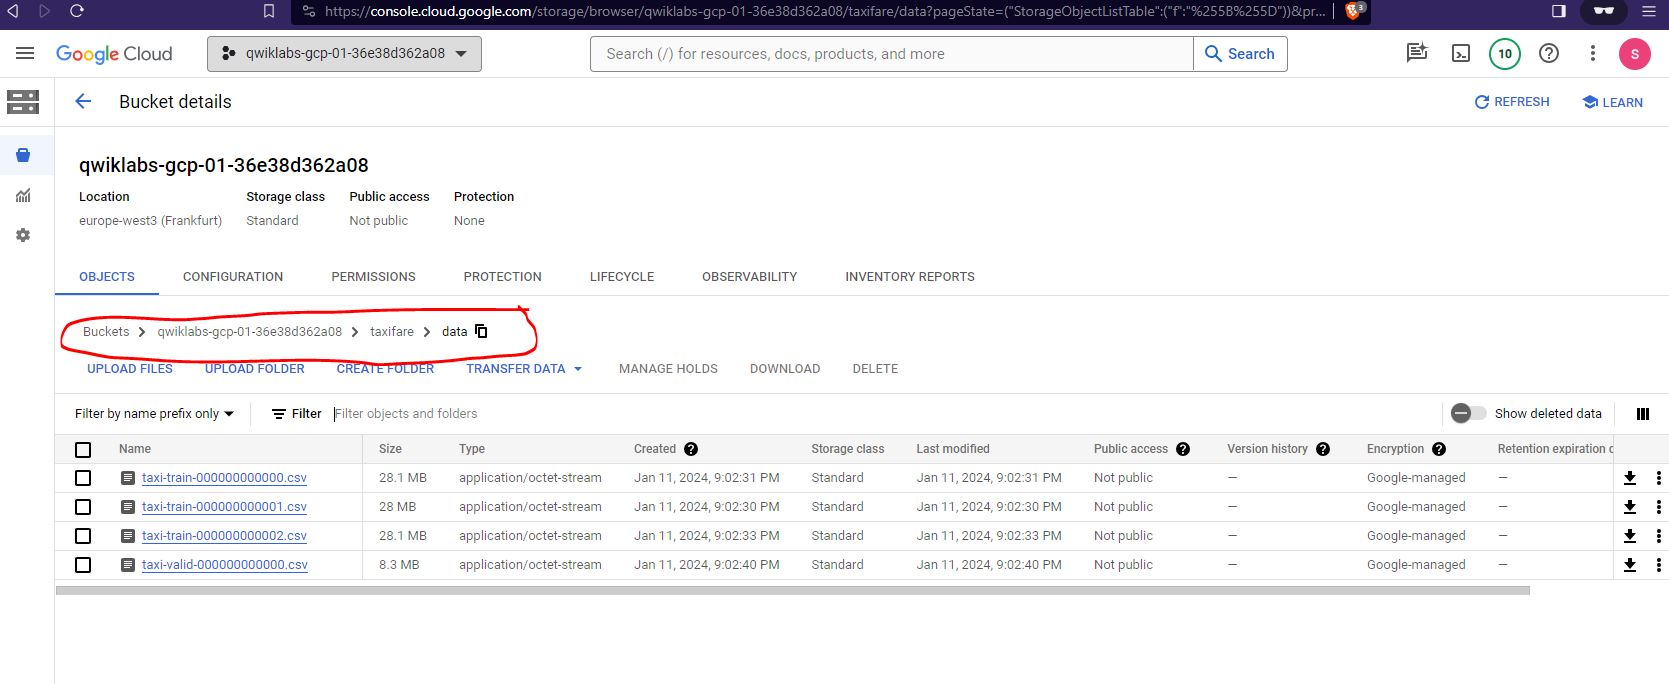

In [ ]:
!gsutil cat gs://$BUCKET/taxifare/data/taxi-train-000000000000.csv | head -2

In [ ]:
!gsutil cat gs://$BUCKET/taxifare/data/taxi-valid-000000000000.csv | head -2

## Make code compatible with Vertex AI Training Service
In order to make our code compatible with Vertex AI Training Service we need to make the following changes:

1. Upload data to Google Cloud Storage (done!)
2. Move code into a trainer Python package
4. Submit training job with `gcloud` to train on Vertex AI

### Move code into a python package

The first thing to do is to convert your training code snippets into a regular Python package. 

A Python package is simply a collection of one or more `.py` files along with an `__init__.py` file to identify the containing directory as a package. The `__init__.py` sometimes contains initialization code but for our purposes an empty file suffices.

#### Create the package directory

Our package directory contains 3 files:

In [ ]:
ls ./taxifare/trainer/

#### Paste existing code into model.py

A Python package requires our code to be in a .py file, as opposed to notebook cells. So, we simply copy and paste our existing code for the previous notebook into a single file.

In the cell below, we write the contents of the cell into `model.py` packaging the model we 
developed in the previous labs so that we can deploy it to Vertex AI Training Service.  

In [ ]:
%%writefile ./taxifare/trainer/model.py
"""Data prep, train and evaluate DNN model."""

import logging
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras import callbacks, models
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Discretization,
    Embedding,
    Flatten,
    Input,
    Lambda,
)
from tensorflow.keras.layers.experimental.preprocessing import HashedCrossing

logging.info(tf.version.VERSION)

CSV_COLUMNS = [
    "fare_amount",
    "pickup_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "key",
]

LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], ["na"], [0.0], [0.0], [0.0], [0.0], [0.0], ["na"]]
UNWANTED_COLS = ["pickup_datetime", "key"]

INPUT_COLS = [
    c for c in CSV_COLUMNS if c != LABEL_COLUMN and c not in UNWANTED_COLS
]

def features_and_labels(row_data):
    for unwanted_col in UNWANTED_COLS:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label


def load_dataset(pattern, batch_size, num_repeat):
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS,
        num_epochs=num_repeat,
        shuffle_buffer_size=1000000,
    )
    return dataset.map(features_and_labels)


def create_train_dataset(pattern, batch_size):
    dataset = load_dataset(pattern, batch_size, num_repeat=None)
    return dataset.prefetch(1)


def create_eval_dataset(pattern, batch_size):
    dataset = load_dataset(pattern, batch_size, num_repeat=1)
    return dataset.prefetch(1)


def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff * londiff + latdiff * latdiff)


def scale_longitude(lon_column):
    return (lon_column + 78) / 8.0


def scale_latitude(lat_column):
    return (lat_column - 37) / 8.0


def transform(inputs, nbuckets):
    transformed = {}

    # Scaling longitude from range [-70, -78] to [0, 1]
    transformed["scaled_plon"] = Lambda(scale_longitude, name="scale_plon")(
        inputs["pickup_longitude"]
    )
    transformed["scaled_dlon"] = Lambda(scale_longitude, name="scale_dlon")(
        inputs["dropoff_longitude"]
    )

    # Scaling latitude from range [37, 45] to [0, 1]
    transformed["scaled_plat"] = Lambda(scale_latitude, name="scale_plat")(
        inputs["pickup_latitude"]
    )
    transformed["scaled_dlat"] = Lambda(scale_latitude, name="scale_dlat")(
        inputs["dropoff_latitude"]
    )

    # Apply euclidean function
    transformed["euclidean_distance"] = Lambda(euclidean, name="euclidean")(
        [
            inputs["pickup_longitude"],
            inputs["pickup_latitude"],
            inputs["dropoff_longitude"],
            inputs["dropoff_latitude"],
        ]
    )

    latbuckets = np.linspace(start=0.0, stop=1.0, num=nbuckets).tolist()
    lonbuckets = np.linspace(start=0.0, stop=1.0, num=nbuckets).tolist()

    # Bucketization with Discretization layer
    plon = Discretization(lonbuckets, name="plon_bkt")(
        transformed["scaled_plon"]
    )
    plat = Discretization(latbuckets, name="plat_bkt")(
        transformed["scaled_plat"]
    )
    dlon = Discretization(lonbuckets, name="dlon_bkt")(
        transformed["scaled_dlon"]
    )
    dlat = Discretization(latbuckets, name="dlat_bkt")(
        transformed["scaled_dlat"]
    )

    # Feature Cross with HashedCrossing layer
    p_fc = HashedCrossing(num_bins=nbuckets * nbuckets, name="p_fc")(
        (plon, plat)
    )
    d_fc = HashedCrossing(num_bins=nbuckets * nbuckets, name="d_fc")(
        (dlon, dlat)
    )
    pd_fc = HashedCrossing(num_bins=nbuckets**4, name="pd_fc")((p_fc, d_fc))

    # Embedding with Embedding layer
    transformed["pd_embed"] = Flatten()(
        Embedding(input_dim=nbuckets**4, output_dim=10, name="pd_embed")(
            pd_fc
        )
    )

    transformed["passenger_count"] = inputs["passenger_count"]

    return transformed


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_dnn_model(nbuckets, nnsize, lr):
    inputs = {
        colname: Input(name=colname, shape=(1,), dtype="float32")
        for colname in INPUT_COLS
    }

    # transforms
    transformed = transform(inputs, nbuckets)
    dnn_inputs = Concatenate()(transformed.values())

    x = dnn_inputs
    for layer, nodes in enumerate(nnsize):
        x = Dense(nodes, activation="relu", name=f"h{layer}")(x)
    output = Dense(1, name="fare")(x)

    model = models.Model(inputs, output)
    # TODO 1a
    lr_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=lr_optimizer, loss="mse", metrics=[rmse, "mse"])

    return model


def train_and_evaluate(hparams):
    # TODO 1b
    batch_size = hparams["batch_size"]
    nbuckets = hparams["nbuckets"]
    lr = hparams["lr"]
    nnsize = [int(s) for s in hparams["nnsize"].split()]
    eval_data_path = hparams["eval_data_path"]
    num_evals = hparams["num_evals"]
    num_examples_to_train_on = hparams["num_examples_to_train_on"]
    output_dir = hparams["output_dir"]
    train_data_path = hparams["train_data_path"]

    model_export_path = os.path.join(output_dir, "savedmodel")
    checkpoint_path = os.path.join(output_dir, "checkpoints")
    tensorboard_path = os.path.join(output_dir, "tensorboard")

    if tf.io.gfile.exists(output_dir):
        tf.io.gfile.rmtree(output_dir)

    model = build_dnn_model(nbuckets, nnsize, lr)
    logging.info(model.summary())

    trainds = create_train_dataset(train_data_path, batch_size)
    evalds = create_eval_dataset(eval_data_path, batch_size)

    steps_per_epoch = num_examples_to_train_on // (batch_size * num_evals)

    checkpoint_cb = callbacks.ModelCheckpoint(
        checkpoint_path, save_weights_only=True, verbose=1
    )
    tensorboard_cb = callbacks.TensorBoard(tensorboard_path, histogram_freq=1)

    history = model.fit(
        trainds,
        validation_data=evalds,
        epochs=num_evals,
        steps_per_epoch=max(1, steps_per_epoch),
        verbose=2,  # 0=silent, 1=progress bar, 2=one line per epoch
        callbacks=[checkpoint_cb, tensorboard_cb],
    )

    # Exporting the model with default serving function.
    model.save(model_export_path)
    return history


### Modify code to read data from and write checkpoint files to GCS 

If you look closely above, you'll notice a new function, `train_and_evaluate` that wraps the code that actually trains the model. This allows us to parametrize the training by passing a dictionary of parameters to this function (e.g, `batch_size`, `num_examples_to_train_on`, `train_data_path` etc.)

This is useful because the output directory, data paths and number of train steps will be different depending on whether we're training locally or in the cloud. Parametrizing allows us to use the same code for both.

We specify these parameters at run time via the command line. Which means we need to add code to parse command line parameters and invoke `train_and_evaluate()` with those params. This is the job of the `task.py` file. 

In [ ]:
%%writefile taxifare/trainer/task.py
"""Argument definitions for model training code in `trainer.model`."""

import argparse

from trainer import model

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--batch_size",
        help="Batch size for training steps",
        type=int,
        default=32,
    )
    parser.add_argument(
        "--eval_data_path",
        help="GCS location pattern of eval files",
        required=True,
    )
    parser.add_argument(
        "--nnsize",
        help="Hidden layer sizes (provide space-separated sizes)",
        default="32 8",
    )
    parser.add_argument(
        "--nbuckets",
        help="Number of buckets to divide lat and lon with",
        type=int,
        default=10,
    )
    parser.add_argument(
        "--lr", help="learning rate for optimizer", type=float, default=0.001
    )
    parser.add_argument(
        "--num_evals",
        help="Number of times to evaluate model on eval data training.",
        type=int,
        default=5,
    )
    parser.add_argument(
        "--num_examples_to_train_on",
        help="Number of examples to train on.",
        type=int,
        default=100,
    )
    parser.add_argument(
        "--output_dir",
        help="GCS location to write checkpoints and export models",
        required=True,
    )
    parser.add_argument(
        "--train_data_path",
        help="GCS location pattern of train files containing eval URLs",
        required=True,
    )
    args = parser.parse_args()
    hparams = args.__dict__

    model.train_and_evaluate(hparams)


### Run trainer module package locally

Now we can test our training code locally as follows using the local test data. We'll run a very small training job over a single file with a small batch size and one eval step.

In [ ]:
%%bash

EVAL_DATA_PATH=../data/taxi-traffic-valid*
TRAIN_DATA_PATH=../data/taxi-traffic-train*
OUTPUT_DIR=./taxifare-model

test ${OUTPUT_DIR} && rm -rf ${OUTPUT_DIR}
export PYTHONPATH=${PYTHONPATH}:${PWD}/taxifare
    
# Run the trainer module package locally with 1 eval

python3 -m trainer.task \
--eval_data_path $EVAL_DATA_PATH \
--output_dir $OUTPUT_DIR \
--train_data_path $TRAIN_DATA_PATH \
--batch_size 5 \
--num_examples_to_train_on 100 \
--num_evals 1 \
--nbuckets 10 \
--lr 0.001 \
--nnsize "32 8"

### Run your training package on Vertex AI using a pre-built container

Once the code works in standalone mode locally, you can run it on the Cloud using Vertex AI and use pre-built containers. First, we need to package our code as a source distribution. For this, we can use `setuptools`. 

In [ ]:
%%writefile taxifare/setup.py
"""Using `setuptools` to create a source distribution."""

from setuptools import find_packages, setup

setup(
    name="taxifare_trainer",
    version="0.1",
    packages=find_packages(),
    include_package_data=True,
    description="Taxifare model training application.",
)

In [ ]:
%%bash
cd taxifare
python ./setup.py sdist --formats=gztar
cd ..

We will store our package in the Cloud Storage bucket.

In [ ]:
# Store the package in the Cloud Storage bucket

!gsutil cp taxifare/dist/taxifare_trainer-0.1.tar.gz gs://$BUCKET/taxifare/

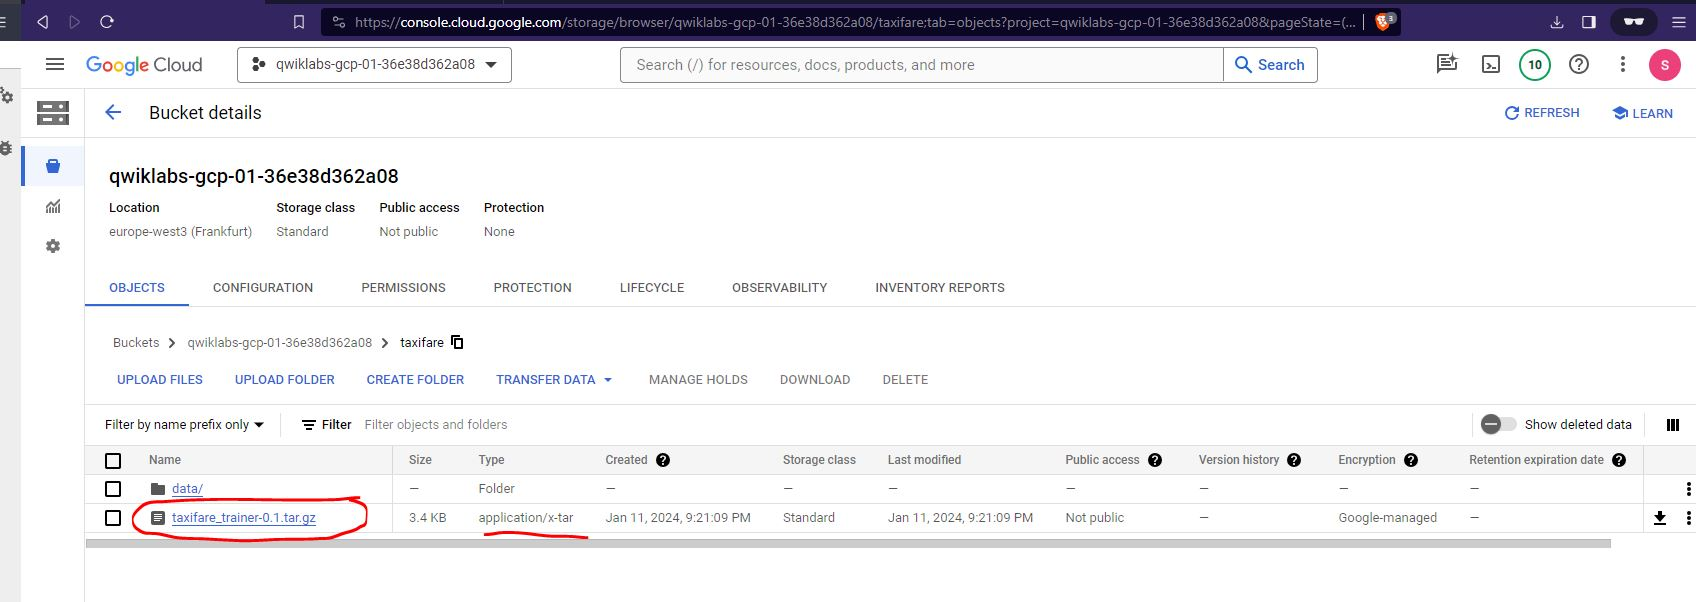

#### Submit Custom Job using the `gcloud` CLI

To submit this source distribution the Cloud we use [`gcloud ai custom-jobs create`](https://cloud.google.com/sdk/gcloud/reference/ai/custom-jobs/create) and simply specify some additional parameters for Vertex AI Training service:
- job_name: A unique identifier for the Cloud job. We usually append system time to ensure uniqueness
- region: Cloud region to train in. See [here](https://cloud.google.com/vertex-ai/docs/general/locations) for supported Vertex AI Custom model training regions

The arguments within `--args` are sent to our `task.py`.

Because this is on the entire dataset, it will take a while. You can monitor the job from the GCP console in the Vertex AI Training section.

In [ ]:
%%bash

# Output directory and jobID
TIMESTAMP=$(date -u +%Y%m%d_%H%M%S)
OUTDIR=gs://${BUCKET}/taxifare/trained_model_$TIMESTAMP
JOB_NAME=taxifare_$TIMESTAMP
echo ${OUTDIR} ${REGION} ${JOB_NAME}

PYTHON_PACKAGE_URIS=gs://${BUCKET}/taxifare/taxifare_trainer-0.1.tar.gz
MACHINE_TYPE=n1-standard-4
REPLICA_COUNT=1
PYTHON_PACKAGE_EXECUTOR_IMAGE_URI="us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-8:latest"
PYTHON_MODULE=trainer.task

# Model and training hyperparameters
BATCH_SIZE=50
NUM_EXAMPLES_TO_TRAIN_ON=5000
NUM_EVALS=100
NBUCKETS=10
LR=0.001
NNSIZE="32 8"

# GCS paths
GCS_PROJECT_PATH=gs://$BUCKET/taxifare
DATA_PATH=$GCS_PROJECT_PATH/data
TRAIN_DATA_PATH=$DATA_PATH/taxi-train*
EVAL_DATA_PATH=$DATA_PATH/taxi-valid*

WORKER_POOL_SPEC="machine-type=$MACHINE_TYPE,\
replica-count=$REPLICA_COUNT,\
executor-image-uri=$PYTHON_PACKAGE_EXECUTOR_IMAGE_URI,\
python-module=$PYTHON_MODULE"

ARGS="--eval_data_path=$EVAL_DATA_PATH,\
--output_dir=$OUTDIR,\
--train_data_path=$TRAIN_DATA_PATH,\
--batch_size=$BATCH_SIZE,\
--num_examples_to_train_on=$NUM_EXAMPLES_TO_TRAIN_ON,\
--num_evals=$NUM_EVALS,\
--nbuckets=$NBUCKETS,\
--lr=$LR,\
--nnsize=$NNSIZE"

# Create a custom job

gcloud ai custom-jobs create \
  --region=${REGION} \
  --display-name=$JOB_NAME \
  --python-package-uris=$PYTHON_PACKAGE_URIS \
  --worker-pool-spec=$WORKER_POOL_SPEC \
  --args="$ARGS"

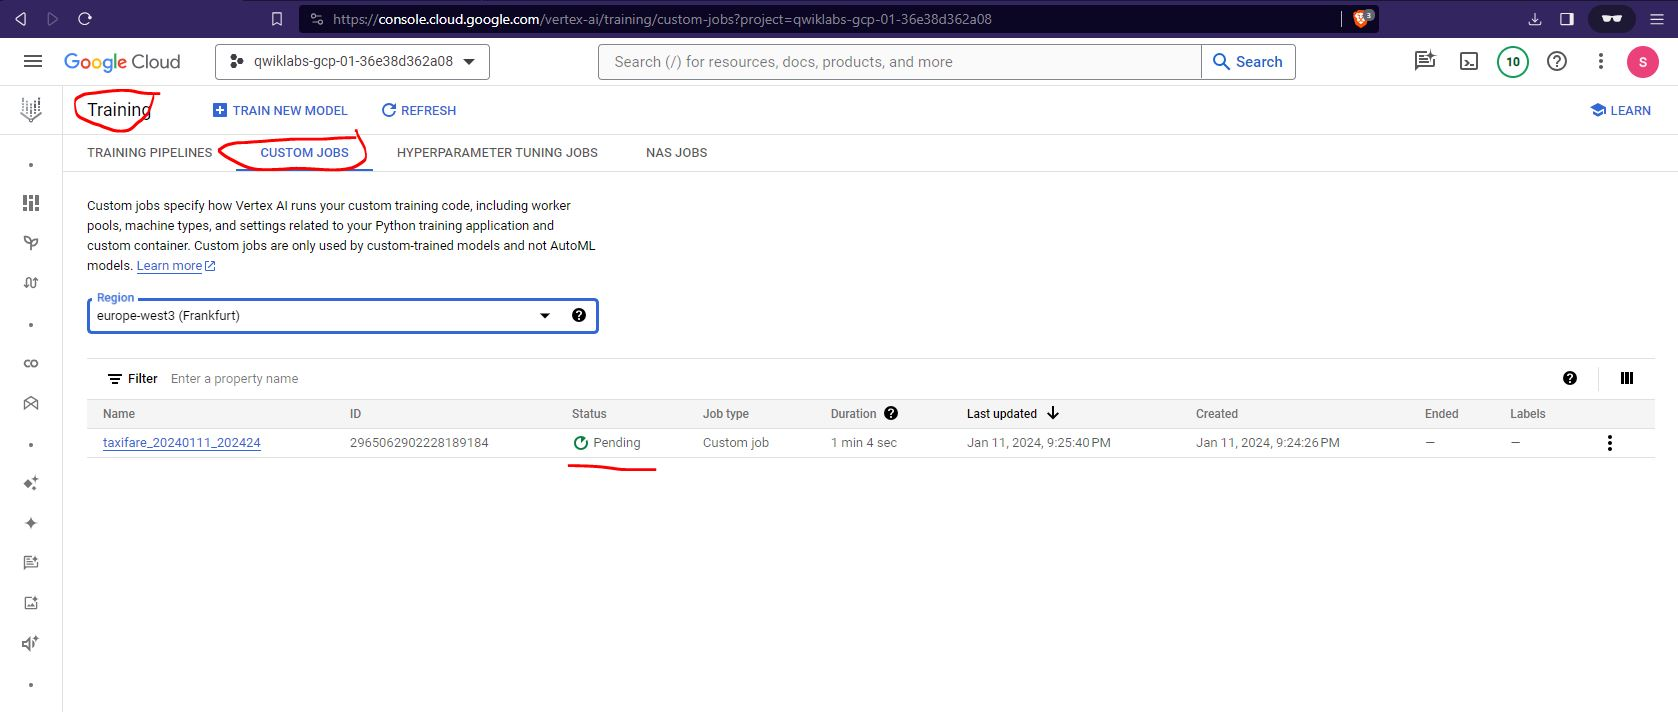

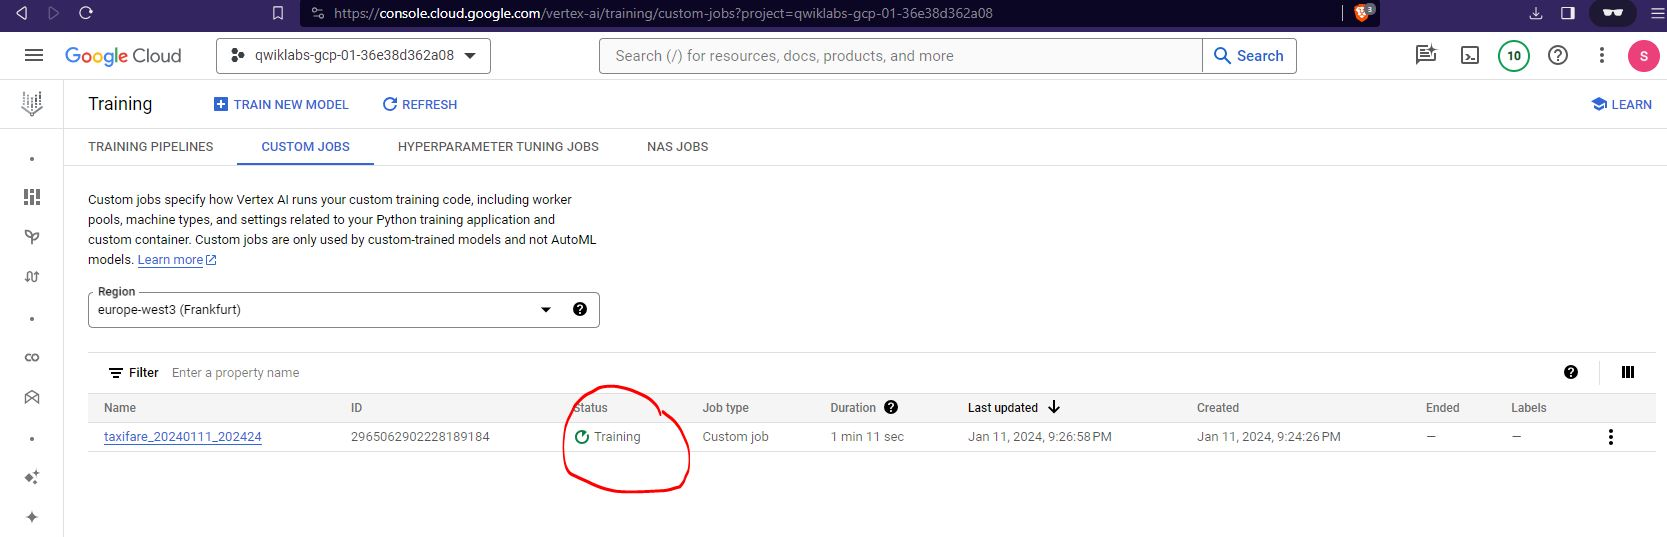

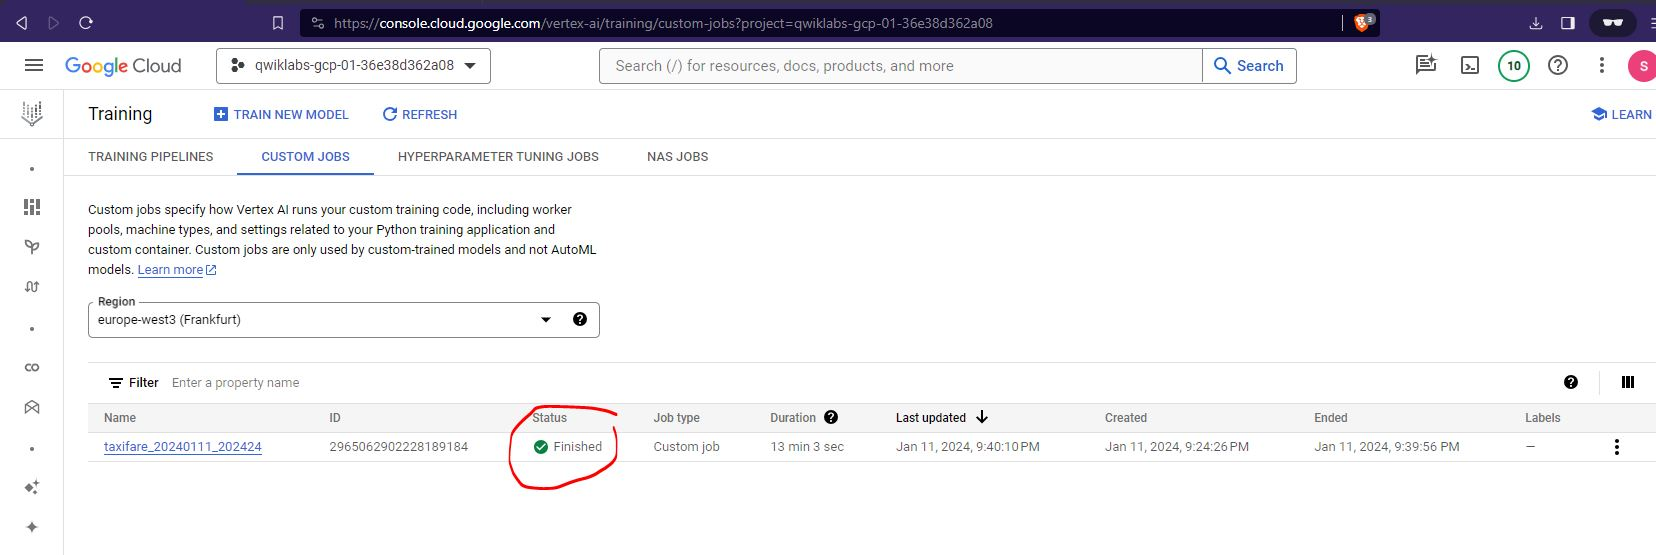

#### Submit Custom Job using the Vertex AI Python SDK

The `gcloud` CLI is just one of multiple ways to interact with Vertex AI, which also include the Console GUI, directly calling the REST APIs (e.g. using `curl`), and the most flexible interface being the Vertex AI SDK available in multiple languages.

Below, we use the Vertex AI Python SDK to accomplish the same Pre-Built Container training as above -- getting familiar with the SDK will come in handy later when we use advanced features such as hyperparameter tuning.

In [ ]:
from datetime import datetime
from google.cloud import aiplatform


# Output directory and jobID
timestamp_str=datetime.strftime(datetime.now(), '%y%m%d_%H%M%S')
OUTDIR=f"gs://{BUCKET}/taxifare/trained_model_{timestamp_str}"
JOB_NAME=f"taxifare_{timestamp_str}"
print(OUTDIR, REGION, JOB_NAME)


# Vertex AI machines to use for training
PYTHON_PACKAGE_URIS=f"gs://{BUCKET}/taxifare/taxifare_trainer-0.1.tar.gz"
MACHINE_TYPE="n1-standard-4"
REPLICA_COUNT=1
PYTHON_PACKAGE_EXECUTOR_IMAGE_URI="us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-8:latest"
PYTHON_MODULE="trainer.task"

# Model and training hyperparameters
BATCH_SIZE=50
NUM_EXAMPLES_TO_TRAIN_ON=5000
NUM_EVALS=100
NBUCKETS=10
LR=0.001
NNSIZE="32 8"


# GCS paths.
GCS_PROJECT_PATH=f"gs://{BUCKET}/taxifare"
DATA_PATH=f"{GCS_PROJECT_PATH}/data"
TRAIN_DATA_PATH=f"{DATA_PATH}/taxi-train*"
EVAL_DATA_PATH=f"{DATA_PATH}/taxi-valid*"

def create_custom_job_sample(
    project: str,
    display_name: str,
    executor_image_uri: str,
    package_uri: str,
    python_module: str,
    location: str = REGION,
    api_endpoint: str = f"{REGION}-aiplatform.googleapis.com",
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.JobServiceClient(client_options=client_options)
    custom_job = {
        "display_name": display_name,
        "job_spec": {
            "worker_pool_specs": [
                {
                    "machine_spec": {
                        "machine_type": MACHINE_TYPE,
                    },
                    "replica_count": REPLICA_COUNT,
                    "python_package_spec": {
                        "executor_image_uri": executor_image_uri,
                        "package_uris": [package_uri],
                        "python_module": python_module,
                        "args": [
                            f"--eval_data_path={EVAL_DATA_PATH}",
                            f"--output_dir={OUTDIR}",
                            f"--train_data_path={TRAIN_DATA_PATH}",
                            f"--batch_size={BATCH_SIZE}",
                            f"--num_examples_to_train_on={NUM_EXAMPLES_TO_TRAIN_ON}",
                            f"--num_evals={NUM_EVALS}",
                            f"--nbuckets={NBUCKETS}",
                            f"--lr={LR}",
                            f"--nnsize={NNSIZE}"
                        ],
                    },
                }
            ],
        },
    }
    parent = f"projects/{project}/locations/{location}"
    response = client.create_custom_job(parent=parent, custom_job=custom_job)
    print("response:", response)

create_custom_job_sample(
    project=PROJECT,
    display_name=JOB_NAME,
    executor_image_uri=PYTHON_PACKAGE_EXECUTOR_IMAGE_URI,
    package_uri=PYTHON_PACKAGE_URIS,
    python_module=PYTHON_MODULE)

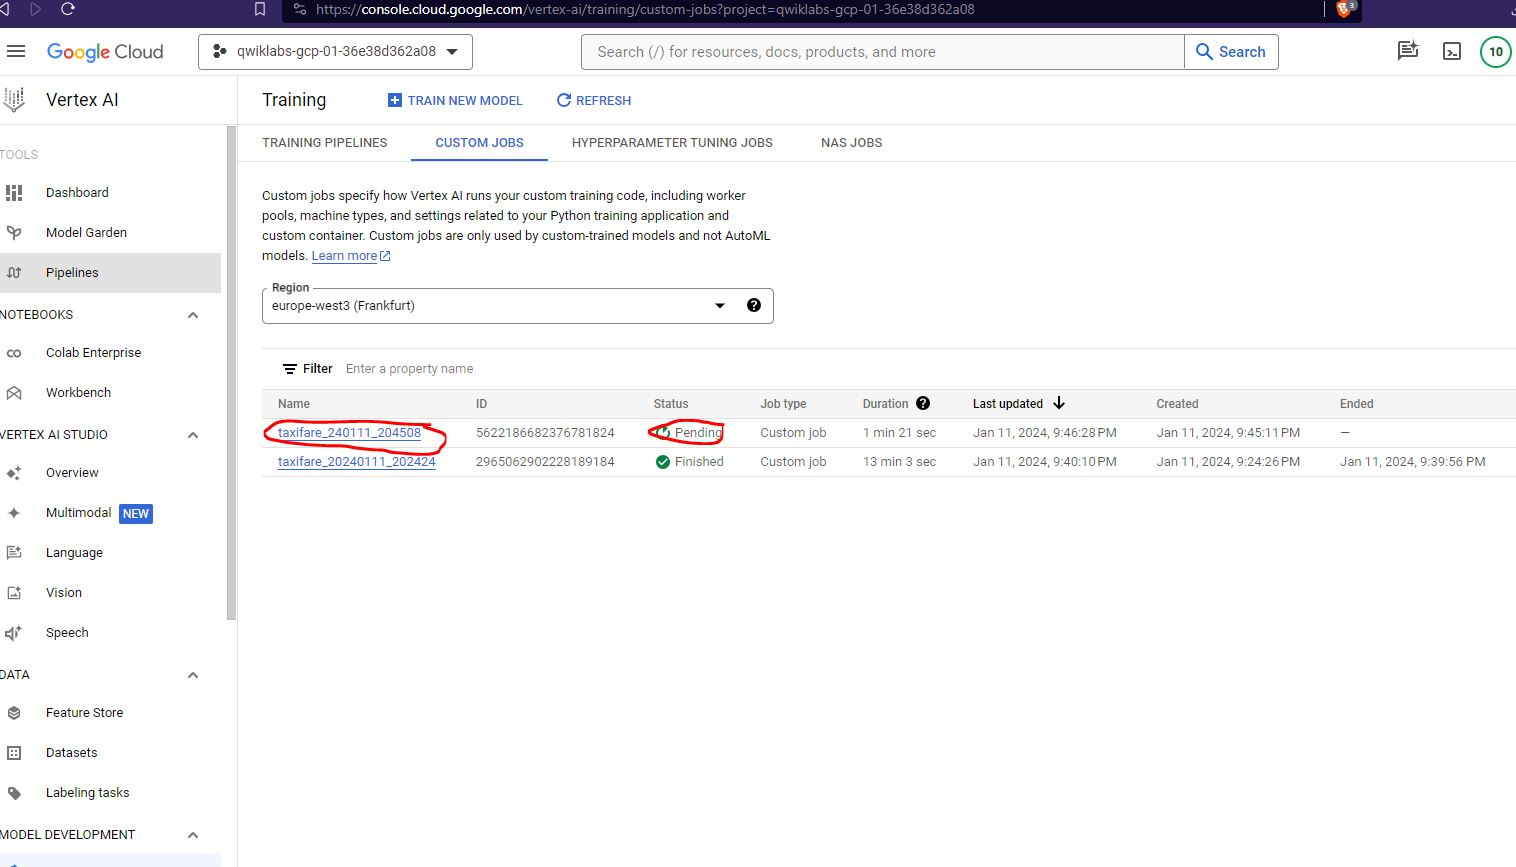